# **Human Activity Recognition using LSTM**

Objective:
Classify human activities using multivariate accelerometer and gyroscope signals.

Dataset:
UCI HAR Dataset (50Hz sampling, 128 timestep windows, 6 activities)

Model:
Deep LSTM architecture with regularization

Evaluation:
Accuracy, Confusion Matrix, Precision, Recall, F1-score


# Install & Setup

In [4]:
import os
import json

# Create directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move uploaded kaggle.json to proper folder
!mv kaggle.json /root/.kaggle/

# Set permission
!chmod 600 /root/.kaggle/kaggle.json


!kaggle datasets download -d drsaeedmohsen/ucihar-dataset
!unzip -q ucihar-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/drsaeedmohsen/ucihar-dataset
License(s): unknown
  0% 0.00/59.7M [00:00<?, ?B/s]
100% 59.7M/59.7M [00:00<00:00, 1.73GB/s]
 sample_data  'UCI-HAR Dataset'   ucihar-dataset.zip
ls: cannot access 'UCI HAR Dataset': No such file or directory


In [5]:
!ls
!ls "UCI-HAR-Dataset"

 sample_data  'UCI-HAR Dataset'   ucihar-dataset.zip
ls: cannot access 'UCI-HAR-Dataset': No such file or directory


# Imports & Setup

In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout,
    BatchNormalization, Bidirectional
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [3]:
tf.random.set_seed(42)
np.random.seed(42)


# Load Dataset

In [7]:
def load_signals(folder_path, prefix):
    signals = []
    signal_types = [
        "body_acc_x_",
        "body_acc_y_",
        "body_acc_z_",
        "body_gyro_x_",
        "body_gyro_y_",
        "body_gyro_z_"
    ]

    for signal in signal_types:
        filename = os.path.join(folder_path, signal + prefix + ".txt")
        data = np.loadtxt(filename)
        signals.append(data)

    return np.transpose(np.array(signals), (1, 2, 0))

# Load training data
X_train = load_signals("UCI-HAR Dataset/train/Inertial Signals", "train")
X_test = load_signals("UCI-HAR Dataset/test/Inertial Signals", "test")

y_train = np.loadtxt("UCI-HAR Dataset/train/y_train.txt").astype(int)
y_test = np.loadtxt("UCI-HAR Dataset/test/y_test.txt").astype(int)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (7352, 128, 6)
X_test shape: (2947, 128, 6)


# Class Distribution

In [8]:
from collections import Counter
print("Train distribution:", Counter(y_train))


Train distribution: Counter({np.int64(6): 1407, np.int64(5): 1374, np.int64(4): 1286, np.int64(1): 1226, np.int64(2): 1073, np.int64(3): 986})


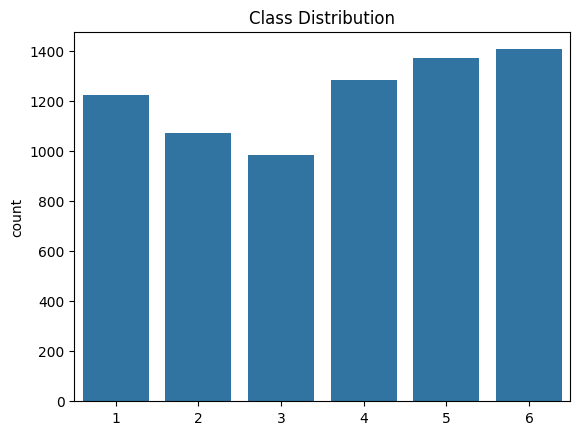

In [9]:
sns.countplot(x=y_train)
plt.title("Class Distribution")
plt.show()


# Standardization

In [10]:
scaler = StandardScaler()

X_train_reshaped = X_train.reshape(-1, 6)
X_test_reshaped  = X_test.reshape(-1, 6)

scaler.fit(X_train_reshaped)

X_train = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test  = scaler.transform(X_test_reshaped).reshape(X_test.shape)


# One-Hot Encoding

In [11]:
y_train = to_categorical(y_train - 1, 6)
y_test  = to_categorical(y_test - 1, 6)


# High-Level Model Architecture

We design a strong but controlled model:

Bidirectional LSTM

Stacked LSTM

BatchNorm

Dropout

Proper regularization

In [15]:
input_layer = Input(shape=(128, 6))

x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(6, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 256)       │       138,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,774 (1.19 MB)

 Trainable params: 312,006 (1.19 MB)

 Non-trainable params: 768 (3.00 KB)

# Callbacks

In [18]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

checkpoint = ModelCheckpoint(
    "best_har_model.h5",
    monitor='val_accuracy',
    save_best_only=True
)


# Training

In [19]:
history = model.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3759 - loss: 1.5812

115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.3766 - loss: 1.5786 - val_accuracy: 0.5596 - val_loss: 1.3310 - learning_rate: 0.0010
Epoch 2/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6059 - loss: 0.8411

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6061 - loss: 0.8406 - val_accuracy: 0.7041 - val_loss: 0.7366 - learning_rate: 0.0010
Epoch 3/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6622 - loss: 0.6569

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6624 - loss: 0.6566 - val_accuracy: 0.7482 - val_loss: 0.5728 - learning_rate: 0.0010
Epoch 4/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.7094 - loss: 0.5920 - val_accuracy: 0.7374 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 5/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7390 - loss: 0.5440

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.7390 - loss: 0.5439 - val_accuracy: 0.7855 - val_loss: 0.4863 - learning_rate: 0.0010
Epoch 6/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7633 - loss: 0.5014 - val_accuracy: 0.7329 - val_loss: 0.6033 - learning_rate: 0.0010
Epoch 7/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7597 - loss: 0.4932

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7598 - loss: 0.4931 - val_accuracy: 0.7944 - val_loss: 0.4939 - learning_rate: 0.0010
Epoch 8/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7868 - loss: 0.4614

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.7868 - loss: 0.4614 - val_accuracy: 0.8062 - val_loss: 0.4627 - learning_rate: 0.0010
Epoch 9/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.7809 - loss: 0.4582 - val_accuracy: 0.6960 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 10/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7511 - loss: 0.4958 - val_accuracy: 0.7991 - val_loss: 0.4999 - learning_rate: 0.0010
Epoch 11/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7907 - loss: 0.4508 - val_accuracy: 0.7937 - val_loss: 0.5801 - learning_rate: 0.0010
Epoch 12/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8021 - loss: 0.4403

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8021 - loss: 0.4403 - val_accuracy: 0.8378 - val_loss: 0.4665 - learning_rate: 0.0010
Epoch 13/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8255 - loss: 0.3889 - val_accuracy: 0.7560 - val_loss: 0.6568 - learning_rate: 0.0010
Epoch 14/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7917 - loss: 0.4436

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7919 - loss: 0.4433 - val_accuracy: 0.8680 - val_loss: 0.4125 - learning_rate: 5.0000e-04
Epoch 15/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8645 - loss: 0.3356 - val_accuracy: 0.8405 - val_loss: 0.4587 - learning_rate: 5.0000e-04
Epoch 16/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8595 - loss: 0.3330 - val_accuracy: 0.8592 - val_loss: 0.4037 - learning_rate: 5.0000e-04
Epoch 17/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8617 - loss: 0.3257

115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8617 - loss: 0.3257 - val_accuracy: 0.8860 - val_loss: 0.3812 - learning_rate: 5.0000e-04
Epoch 18/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8684 - loss: 0.3077 - val_accuracy: 0.8819 - val_loss: 0.3848 - learning_rate: 5.0000e-04
Epoch 19/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8759 - loss: 0.2944

115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8759 - loss: 0.2944 - val_accuracy: 0.8999 - val_loss: 0.3415 - learning_rate: 5.0000e-04
Epoch 20/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8971 - loss: 0.2630 - val_accuracy: 0.8921 - val_loss: 0.3478 - learning_rate: 5.0000e-04
Epoch 21/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8897 - loss: 0.2697 - val_accuracy: 0.8721 - val_loss: 0.4245 - learning_rate: 5.0000e-04
Epoch 22/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8872 - loss: 0.2725 - val_accuracy: 0.8884 - val_loss: 0.3649 - learning_rate: 5.0000e-04
Epoch 23/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8925 - loss: 0.2482 - val_accuracy: 0.8877 - val_loss: 0.3848 - learning_rate: 5.0000e-04
Epoch 24/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9016 - loss: 0.2338 - val_accuracy: 0.8867 - val_loss: 0.3515 - learning_rate: 5.0000e-04
Epoch 25/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9185 - loss: 0.2043 - val_accuracy: 0.9131 - val_loss: 0.3080 - learning_rate: 2.5000e-04
Epoch 26/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9320 - loss: 0.1782

115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9320 - loss: 0.1783 - val_accuracy: 0.9152 - val_loss: 0.3153 - learning_rate: 2.5000e-04
Epoch 27/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9322 - loss: 0.1783

115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9322 - loss: 0.1784 - val_accuracy: 0.9165 - val_loss: 0.3084 - learning_rate: 2.5000e-04
Epoch 28/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9333 - loss: 0.1785 - val_accuracy: 0.9128 - val_loss: 0.3122 - learning_rate: 2.5000e-04
Epoch 29/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9361 - loss: 0.1616 - val_accuracy: 0.9101 - val_loss: 0.3159 - learning_rate: 2.5000e-04
Epoch 30/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9336 - loss: 0.1730 - val_accuracy: 0.9128 - val_loss: 0.3120 - learning_rate: 2.5000e-04
Epoch 31/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9405 - loss: 0.1471

115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.9405 - loss: 0.1472 - val_accuracy: 0.9199 - val_loss: 0.3028 - learning_rate: 1.2500e-04
Epoch 32/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9466 - loss: 0.1458 - val_accuracy: 0.9165 - val_loss: 0.3151 - learning_rate: 1.2500e-04
Epoch 33/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9480 - loss: 0.1376 - val_accuracy: 0.9179 - val_loss: 0.3198 - learning_rate: 1.2500e-04
Epoch 34/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9516 - loss: 0.1308 - val_accuracy: 0.9158 - val_loss: 0.3181 - learning_rate: 1.2500e-04
Epoch 35/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9496 - loss: 0.1375 - val_accuracy: 0.9165 - val_loss: 0.3247 - learning_rate: 1.2500e-04
Epoch 36/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9492 - loss: 0.1255

115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9492 - loss: 0.1256 - val_accuracy: 0.9233 - val_loss: 0.3144 - learning_rate: 1.2500e-04
Epoch 37/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9543 - loss: 0.1228 - val_accuracy: 0.9206 - val_loss: 0.3191 - learning_rate: 6.2500e-05
Epoch 38/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9561 - loss: 0.1172 - val_accuracy: 0.9175 - val_loss: 0.3258 - learning_rate: 6.2500e-05
Epoch 39/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9629 - loss: 0.1068 - val_accuracy: 0.9209 - val_loss: 0.3229 - learning_rate: 6.2500e-05


# Evaluation

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9058 - loss: 0.3356
Test Accuracy: 0.9199185371398926


# Confusion Matrix

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


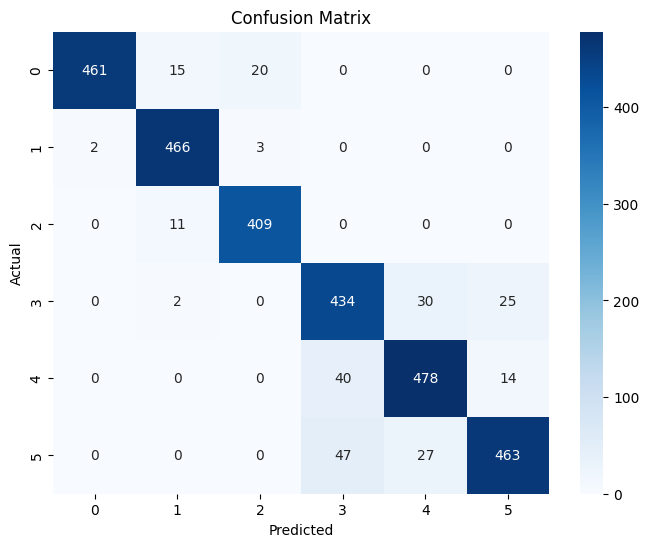

In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Classification Report

In [22]:
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       1.00      0.93      0.96       496
           1       0.94      0.99      0.97       471
           2       0.95      0.97      0.96       420
           3       0.83      0.88      0.86       491
           4       0.89      0.90      0.90       532
           5       0.92      0.86      0.89       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



# Save Final Model

In [24]:
model.save("final_har_model.h5")


In [25]:
from google.colab import files
files.download("best_har_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import joblib

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

# Load Model + Test with Sample Input

In [28]:
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt

# Load model
model = tf.keras.models.load_model("best_har_model.h5")

# Load scaler
scaler = joblib.load("scaler.pkl")

print("Model and scaler loaded successfully.")


Model and scaler loaded successfully.


# Prepare Sample Input

In [30]:
# Take one sample from test set (raw version before scaling if stored)
sample = X_test[0]   # shape (128, 6)

# In real deployment, you would receive raw sensor window here.
sample


array([[ 6.30725375e-02, -2.37746810e-01,  1.00208361e+00,
         1.07409305e+00,  1.39365448e+00,  5.33406104e-01],
       [ 7.05447846e-02, -3.22120269e-01,  1.42900361e+00,
         1.14980411e+00,  1.89049134e+00,  3.81278817e-01],
       [ 6.11002141e-02, -4.25668834e-01,  2.03147385e+00,
         1.22353123e+00,  1.36479321e+00,  3.26275934e-01],
       [ 1.46099912e-01, -4.23221426e-01,  1.89800492e+00,
         1.17716692e+00,  9.77988103e-01,  8.89488634e-02],
       [ 1.51640162e-02, -3.69018971e-01,  1.64939623e+00,
         9.57159823e-01,  1.08775824e+00, -1.01868299e-01],
       [-9.40700091e-02, -3.06069461e-01,  1.72199715e+00,
         7.52539819e-01,  8.75076343e-01, -1.06571729e-01],
       [-3.14524394e-01, -1.45025063e-01,  1.65431956e+00,
         7.23841521e-01,  7.32350971e-01, -1.44307130e-01],
       [-4.80439238e-01, -6.70846534e-02,  1.68073827e+00,
         7.51229642e-01,  7.10755300e-01, -1.27433403e-01],
       [-4.04923680e-01, -1.75545498e-01,  1.795

In [32]:
sample_reshaped = sample.reshape(-1, 6)
sample_scaled = scaler.transform(sample_reshaped).reshape(1, 128, 6)


# Predict

In [33]:
prediction = model.predict(sample_scaled)
predicted_class = np.argmax(prediction)

class_map = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING"
}

print("Predicted Activity:", class_map[predicted_class])
print("Confidence:", np.max(prediction))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Predicted Activity: WALKING_UPSTAIRS
Confidence: 0.5092551


# Plot Sensor Signals (Very Useful for Analysis)

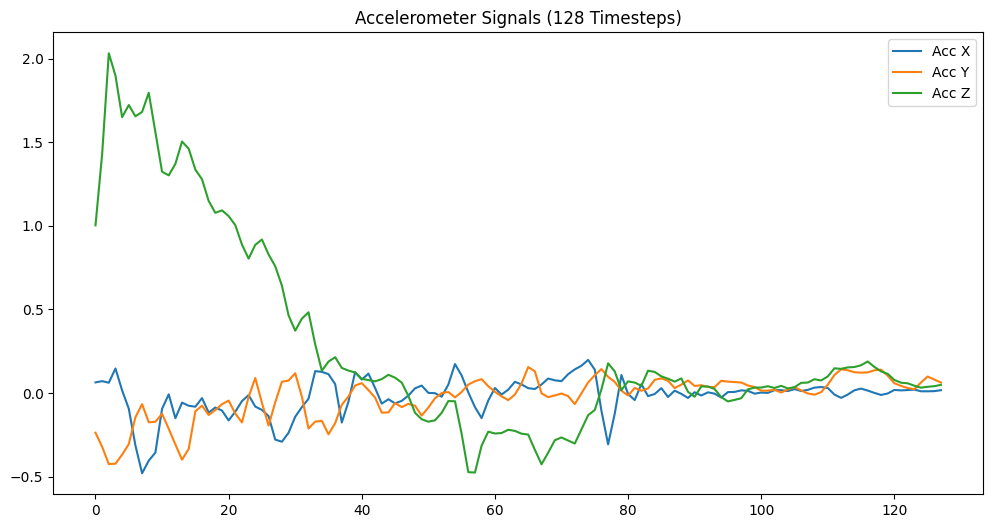

In [34]:
plt.figure(figsize=(12,6))
plt.plot(sample[:,0], label="Acc X")
plt.plot(sample[:,1], label="Acc Y")
plt.plot(sample[:,2], label="Acc Z")

plt.title("Accelerometer Signals (128 Timesteps)")
plt.legend()
plt.show()


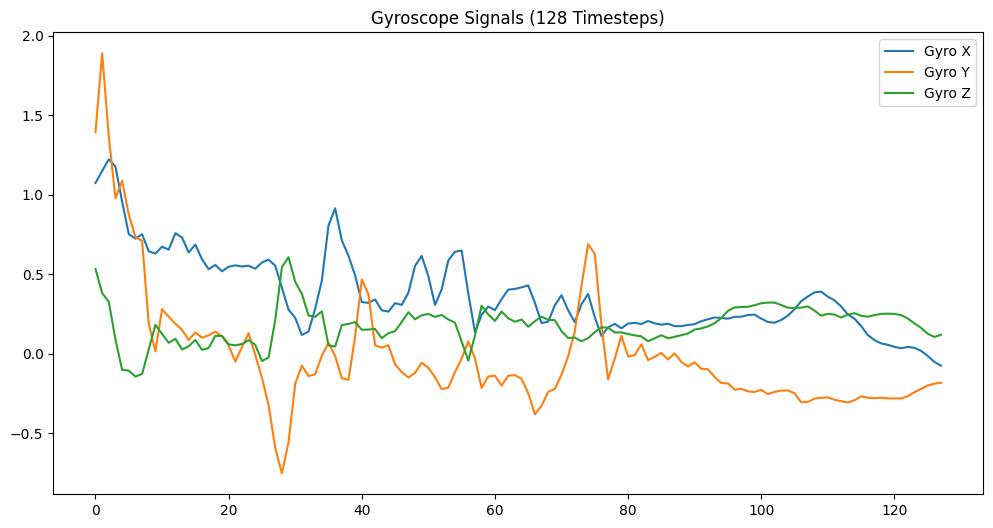

In [35]:
plt.figure(figsize=(12,6))
plt.plot(sample[:,3], label="Gyro X")
plt.plot(sample[:,4], label="Gyro Y")
plt.plot(sample[:,5], label="Gyro Z")

plt.title("Gyroscope Signals (128 Timesteps)")
plt.legend()
plt.show()
